In [1]:
import datetime, warnings, scipy 
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.patches import ConnectionPatch
from collections import OrderedDict
from matplotlib.gridspec import GridSpec
from sklearn import metrics, linear_model
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from scipy.optimize import curve_fit
plt.rcParams["patch.force_edgecolor"] = True
plt.style.use('fivethirtyeight')
mpl.rc('patch', edgecolor = 'dimgray', linewidth=1)
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "last_expr"
pd.options.display.max_columns = 50
%matplotlib inline
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv('../Desktop/Прога/Прога/flights.csv', low_memory=False)
print('Dataframe dimensions:', df.shape)
#____________________________________________________________
# gives some infos on columns types and number of null values
tab_info=pd.DataFrame(df.dtypes).T.rename(index={0:'column type'})
tab_info=tab_info.append(pd.DataFrame(df.isnull().sum()).T.rename(index={0:'null values (nb)'}))
tab_info=tab_info.append(pd.DataFrame(df.isnull().sum()/df.shape[0]*100)
                         .T.rename(index={0:'null values (%)'}))
tab_info

Dataframe dimensions: (5819079, 31)


,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,DEPARTURE_TIME,DEPARTURE_DELAY,TAXI_OUT,WHEELS_OFF,SCHEDULED_TIME,ELAPSED_TIME,AIR_TIME,DISTANCE,WHEELS_ON,TAXI_IN,SCHEDULED_ARRIVAL,ARRIVAL_TIME,ARRIVAL_DELAY,DIVERTED,CANCELLED,CANCELLATION_REASON,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY
column type,int64,int64,int64,int64,object,int64,object,object,object,int64,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,int64,float64,float64,int64,int64,object,float64,float64,float64,float64,float64
null values (nb),0,0,0,0,0,0,14721,0,0,0,86153,86153,89047,89047,6,105071,105071,0,92513,92513,0,92513,105071,0,0,5729195,4755640,4755640,4755640,4755640,4755640
null values (%),0,0,0,0,0,0,0.252978,0,0,0,1.48053,1.48053,1.53026,1.53026,0.000103109,1.80563,1.80563,0,1.58982,1.58982,0,1.58982,1.80563,0,0,98.4554,81.725,81.725,81.725,81.725,81.725


In [3]:
airports = pd.read_csv("../Desktop/Прога/Прога/airports.csv")


In [4]:
df['DATE'] = pd.to_datetime(df[['YEAR','MONTH', 'DAY']])
#_________________________________________________________
# Function that convert the 'HHMM' string to datetime.time
def format_heure(chaine):
    if pd.isnull(chaine):
        return np.nan
    else:
        if chaine == 2400: chaine = 0
        chaine = "{0:04d}".format(int(chaine))
        heure = datetime.time(int(chaine[0:2]), int(chaine[2:4]))
        return heure
#_____________________________________________________________________
# Function that combines a date and time to produce a datetime.datetime
def combine_date_heure(x):
    if pd.isnull(x[0]) or pd.isnull(x[1]):
        return np.nan
    else:
        return datetime.datetime.combine(x[0],x[1])
#_______________________________________________________________________________
# Function that combine two columns of the dataframe to create a datetime format
def create_flight_time(df, col):    
    liste = []
    for index, cols in df[['DATE', col]].iterrows():    
        if pd.isnull(cols[1]):
            liste.append(np.nan)
        elif float(cols[1]) == 2400:
            cols[0] += datetime.timedelta(days=1)
            cols[1] = datetime.time(0,0)
            liste.append(combine_date_heure(cols))
        else:
            cols[1] = format_heure(cols[1])
            liste.append(combine_date_heure(cols))
    return pd.Series(liste)

df['SCHEDULED_DEPARTURE'] = create_flight_time(df, 'SCHEDULED_DEPARTURE')
df['DEPARTURE_TIME'] = df['DEPARTURE_TIME'].apply(format_heure)
df['SCHEDULED_ARRIVAL'] = df['SCHEDULED_ARRIVAL'].apply(format_heure)
df['ARRIVAL_TIME'] = df['ARRIVAL_TIME'].apply(format_heure)
#__________________________________________________________________________
df.loc[:5, ['SCHEDULED_DEPARTURE', 'SCHEDULED_ARRIVAL', 'DEPARTURE_TIME',
             'ARRIVAL_TIME', 'DEPARTURE_DELAY', 'ARRIVAL_DELAY']]

,SCHEDULED_DEPARTURE,SCHEDULED_ARRIVAL,DEPARTURE_TIME,ARRIVAL_TIME,DEPARTURE_DELAY,ARRIVAL_DELAY
0,2015-01-01 00:05:00,04:30:00,23:54:00,04:08:00,-11.0,-22.0
1,2015-01-01 00:10:00,07:50:00,00:02:00,07:41:00,-8.0,-9.0
2,2015-01-01 00:20:00,08:06:00,00:18:00,08:11:00,-2.0,5.0
3,2015-01-01 00:20:00,08:05:00,00:15:00,07:56:00,-5.0,-9.0
4,2015-01-01 00:25:00,03:20:00,00:24:00,02:59:00,-1.0,-21.0
5,2015-01-01 00:25:00,06:02:00,00:20:00,06:10:00,-5.0,8.0


In [5]:
variables_to_remove = ['TAXI_OUT', 'TAXI_IN', 'WHEELS_ON', 'WHEELS_OFF', 'YEAR', 
                       'MONTH','DAY','DAY_OF_WEEK','DATE', 'AIR_SYSTEM_DELAY',
                       'SECURITY_DELAY', 'AIRLINE_DELAY', 'LATE_AIRCRAFT_DELAY',
                       'WEATHER_DELAY', 'DIVERTED', 'CANCELLED', 'CANCELLATION_REASON',
                       'FLIGHT_NUMBER', 'TAIL_NUMBER', 'AIR_TIME']
df.drop(variables_to_remove, axis = 1, inplace = True)
df = df[['AIRLINE', 'ORIGIN_AIRPORT', 'DESTINATION_AIRPORT',
        'SCHEDULED_DEPARTURE', 'DEPARTURE_TIME', 'DEPARTURE_DELAY',
        'SCHEDULED_ARRIVAL', 'ARRIVAL_TIME', 'ARRIVAL_DELAY',
        'SCHEDULED_TIME', 'ELAPSED_TIME']]
df[:5]

,AIRLINE,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,DEPARTURE_TIME,DEPARTURE_DELAY,SCHEDULED_ARRIVAL,ARRIVAL_TIME,ARRIVAL_DELAY,SCHEDULED_TIME,ELAPSED_TIME
0,AS,ANC,SEA,2015-01-01 00:05:00,23:54:00,-11.0,04:30:00,04:08:00,-22.0,205.0,194.0
1,AA,LAX,PBI,2015-01-01 00:10:00,00:02:00,-8.0,07:50:00,07:41:00,-9.0,280.0,279.0
2,US,SFO,CLT,2015-01-01 00:20:00,00:18:00,-2.0,08:06:00,08:11:00,5.0,286.0,293.0
3,AA,LAX,MIA,2015-01-01 00:20:00,00:15:00,-5.0,08:05:00,07:56:00,-9.0,285.0,281.0
4,AS,SEA,ANC,2015-01-01 00:25:00,00:24:00,-1.0,03:20:00,02:59:00,-21.0,235.0,215.0


In [6]:
missing_df = df.isnull().sum(axis=0).reset_index()
missing_df.columns = ['variable', 'missing values']
missing_df['filling factor (%)']=(df.shape[0]-missing_df['missing values'])/df.shape[0]*100
missing_df.sort_values('filling factor (%)').reset_index(drop = True)

,variable,missing values,filling factor (%)
0,ARRIVAL_DELAY,52557,97.217177
1,ELAPSED_TIME,52557,97.217177
2,ARRIVAL_TIME,49076,97.401492
3,DEPARTURE_TIME,46608,97.532169
4,DEPARTURE_DELAY,46608,97.532169
5,SCHEDULED_TIME,4,99.999788
6,AIRLINE,0,100.000000
7,ORIGIN_AIRPORT,0,100.000000
8,DESTINATION_AIRPORT,0,100.000000
9,SCHEDULED_DEPARTURE,0,100.000000


In [7]:
df.dropna(inplace = True)

In [8]:
airlines_names = pd.read_csv('../Desktop/Прога/Прога/airlines.csv')
abbr_companies = airlines_names.set_index('IATA_CODE')['AIRLINE'].to_dict()
airlines_names

,IATA_CODE,AIRLINE
0,UA,United Air Lines Inc.
1,AA,American Airlines Inc.
2,US,US Airways Inc.
3,F9,Frontier Airlines Inc.
4,B6,JetBlue Airways
5,OO,Skywest Airlines Inc.
6,AS,Alaska Airlines Inc.
7,NK,Spirit Air Lines
8,WN,Southwest Airlines Co.
9,DL,Delta Air Lines Inc.


In [9]:
del df['ARRIVAL_DELAY']

In [10]:
del df['ELAPSED_TIME']
del df['ARRIVAL_TIME']
df

,AIRLINE,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,DEPARTURE_TIME,DEPARTURE_DELAY,SCHEDULED_ARRIVAL,SCHEDULED_TIME
0,AS,ANC,SEA,2015-01-01 00:05:00,23:54:00,-11.0,04:30:00,205.0
1,AA,LAX,PBI,2015-01-01 00:10:00,00:02:00,-8.0,07:50:00,280.0
2,US,SFO,CLT,2015-01-01 00:20:00,00:18:00,-2.0,08:06:00,286.0
3,AA,LAX,MIA,2015-01-01 00:20:00,00:15:00,-5.0,08:05:00,285.0
4,AS,SEA,ANC,2015-01-01 00:25:00,00:24:00,-1.0,03:20:00,235.0
...,...,...,...,...,...,...,...,...
1888617,B6,JFK,BQN,2015-04-30 23:59:00,23:56:00,-3.0,03:39:00,220.0
1888618,B6,JFK,PSE,2015-04-30 23:59:00,23:53:00,-6.0,03:48:00,229.0
1888619,B6,JFK,SJU,2015-04-30 23:59:00,23:58:00,-1.0,03:40:00,221.0
1888620,B6,DEN,JFK,2015-04-30 23:59:00,00:14:00,15.0,05:34:00,215.0


In [45]:
from sklearn.model_selection import train_test_split
#import time

# Extract the labels
df2 = df
labels = df2['DEPARTURE_DELAY']
df2['SCHEDULED_DEPARTURE'] =  df2['SCHEDULED_DEPARTURE'].apply(lambda x:x.time())
df2['SCHEDULED_DEPARTURE'] = df2['SCHEDULED_DEPARTURE'].apply(lambda x:float(x.hour*3600+x.minute*60+x.second))
del df2['DEPARTURE_DELAY']

Y = np.array(labels)
X = np.array(df2)

# 30% examples in test data
train_x, test_x, train_y, test_y = train_test_split(X, Y, test_size = 0.3, random_state = 42)

In [11]:
airlines_vector = np.array(airlines_names['IATA_CODE'])
airoport_vector = np.array(airports['IATA_CODE'])
airlines_shape = airlines_vector.shape[0]
airoport_shape = airoport_vector.shape[0]
airlines_map = {airlines_vector[i] : i for i in range(airlines_shape)}
airoport_map = {airoport_vector[i] : i for i in range(airoport_shape)}
for a in airlines_vector:
    df.loc[df["AIRLINE"] == a,"AIRLINE"] = airlines_map[a]
for a in airoport_vector:
    df.loc[df["ORIGIN_AIRPORT"] == a,"ORIGIN_AIRPORT"] = airoport_map[a]
for a in airoport_vector:
    df.loc[df["DESTINATION_AIRPORT"] == a,"DESTINATION_AIRPORT"] = airoport_map[a]
df

,AIRLINE,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,DEPARTURE_TIME,DEPARTURE_DELAY,SCHEDULED_ARRIVAL,SCHEDULED_TIME
0,6,17,277,2015-01-01 00:05:00,23:54:00,-11.0,04:30:00,205.0
1,1,176,235,2015-01-01 00:10:00,00:02:00,-8.0,07:50:00,280.0
2,2,278,66,2015-01-01 00:20:00,00:18:00,-2.0,08:06:00,286.0
3,1,176,203,2015-01-01 00:20:00,00:15:00,-5.0,08:05:00,285.0
4,6,277,17,2015-01-01 00:25:00,00:24:00,-1.0,03:20:00,235.0
...,...,...,...,...,...,...,...,...
1888617,4,166,42,2015-04-30 23:59:00,23:56:00,-3.0,03:39:00,220.0
1888618,4,166,248,2015-04-30 23:59:00,23:53:00,-6.0,03:48:00,229.0
1888619,4,166,285,2015-04-30 23:59:00,23:58:00,-1.0,03:40:00,221.0
1888620,4,85,166,2015-04-30 23:59:00,00:14:00,15.0,05:34:00,215.0


In [12]:
df['DEPARTURE_TIME'] = df['DEPARTURE_TIME'].apply(lambda x:float(x.hour*3600+x.minute*60+x.second))
df['SCHEDULED_ARRIVAL'] = df['SCHEDULED_ARRIVAL'].apply(lambda x:float(x.hour*3600+x.minute*60+x.second))
labels = df['DEPARTURE_DELAY']
del df['DEPARTURE_DELAY']
del df['SCHEDULED_DEPARTURE']
df

,AIRLINE,ORIGIN_AIRPORT,DESTINATION_AIRPORT,DEPARTURE_TIME,SCHEDULED_ARRIVAL,SCHEDULED_TIME
0,6,17,277,86040.0,16200.0,205.0
1,1,176,235,120.0,28200.0,280.0
2,2,278,66,1080.0,29160.0,286.0
3,1,176,203,900.0,29100.0,285.0
4,6,277,17,1440.0,12000.0,235.0
...,...,...,...,...,...,...
1888617,4,166,42,86160.0,13140.0,220.0
1888618,4,166,248,85980.0,13680.0,229.0
1888619,4,166,285,86280.0,13200.0,221.0
1888620,4,85,166,840.0,20040.0,215.0


In [13]:
Y = np.array(labels)
X = np.array(df)

# 30% examples in test data
train_x, test_x, train_y, test_y = train_test_split(X, Y, test_size = 0.3, random_state = 42)

In [14]:
from sklearn.ensemble import RandomForestRegressor

  

 # создать объект регрессора

regressor = RandomForestRegressor(n_estimators = 150, max_depth = 74,bootstrap = True, max_features = 'sqrt', random_state = 23)

  
# установить регрессор с данными x и y
regressor.fit(train_x, train_y)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=74,
                      max_features='sqrt', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=150,
                      n_jobs=None, oob_score=False, random_state=23, verbose=0,
                      warm_start=False)

In [15]:
Y_pred=regressor.predict(test_x)

In [17]:
#Y_pred.reshape(-1, 1)
#test_y.reshape(-1, 1)
#regressor.score(test_x, test_y)

In [16]:
Y_pred

array([-0.07333333, -6.06      , -5.52      , ...,  2.00666667,
       -7.        , -0.95333333])

In [17]:
test_y

array([ 0., -6., -5., ...,  2., -7., -1.])

In [18]:
score = 0.0
for i in range(Y_pred.shape[0]):
    score += (Y_pred[i]**2 + test_y[i]**2)
score /= Y_pred.shape[0]+test_y.shape[0];
score = score**0.5
score

35.293324929837226

In [25]:
Y_pred.shape[0]

550820

In [27]:
test_y.shape[0]

550820

In [21]:
class Figure_style():
    #_________________________________________________________________
    def __init__(self, size_x = 11, size_y = 5, nrows = 1, ncols = 1):
        sns.set_style("white")
        sns.set_context("notebook", font_scale=1.2, rc={"lines.linewidth": 2.5})
        self.fig, axs = plt.subplots(nrows = nrows, ncols = ncols, figsize=(size_x,size_y,))
        #________________________________
        # convert self.axs to 2D array
        if nrows == 1 and ncols == 1:
            self.axs = np.reshape(axs, (1, -1))
        elif nrows == 1:
            self.axs = np.reshape(axs, (1, -1))
        elif ncols == 1:
            self.axs = np.reshape(axs, (-1, 1))
    #_____________________________
    def pos_update(self, ix, iy):
        self.ix, self.iy = ix, iy
    #_______________
    def style(self):
        self.axs[self.ix, self.iy].spines['right'].set_visible(False)
        self.axs[self.ix, self.iy].spines['top'].set_visible(False)
        self.axs[self.ix, self.iy].yaxis.grid(color='lightgray', linestyle=':')
        self.axs[self.ix, self.iy].xaxis.grid(color='lightgray', linestyle=':')
        self.axs[self.ix, self.iy].tick_params(axis='both', which='major',
                                               labelsize=10, size = 5)
    #________________________________________
    def draw_legend(self, location='upper right'):
        legend = self.axs[self.ix, self.iy].legend(loc = location, shadow=True,
                                        facecolor = 'g', frameon = True)
        legend.get_frame().set_facecolor('whitesmoke')
    #_________________________________________________________________________________
    def cust_plot(self, x, y, color='b', linestyle='-', linewidth=1, marker=None, label=''):
        if marker:
            markerfacecolor, marker, markersize = marker[:]
            self.axs[self.ix, self.iy].plot(x, y, color = color, linestyle = linestyle,
                                linewidth = linewidth, marker = marker, label = label,
                                markerfacecolor = markerfacecolor, markersize = markersize)
        else:
            self.axs[self.ix, self.iy].plot(x, y, color = color, linestyle = linestyle,
                                        linewidth = linewidth, label=label)
        self.fig.autofmt_xdate()
    #________________________________________________________________________
    def cust_plot_date(self, x, y, color='lightblue', linestyle='-',
                       linewidth=1, markeredge=False, label=''):
        markeredgewidth = 1 if markeredge else 0
        self.axs[self.ix, self.iy].plot_date(x, y, color='lightblue', markeredgecolor='grey',
                                  markeredgewidth = markeredgewidth, label=label)
    #________________________________________________________________________
    def cust_scatter(self, x, y, color = 'lightblue', markeredge = False, label=''):
        markeredgewidth = 1 if markeredge else 0
        self.axs[self.ix, self.iy].scatter(x, y, color=color,  edgecolor='grey',
                                  linewidths = markeredgewidth, label=label)    
    #___________________________________________
    def set_xlabel(self, label, fontsize = 14):
        self.axs[self.ix, self.iy].set_xlabel(label, fontsize = fontsize)
    #___________________________________________
    def set_ylabel(self, label, fontsize = 14):
        self.axs[self.ix, self.iy].set_ylabel(label, fontsize = fontsize)
    #____________________________________
    def set_xlim(self, lim_inf, lim_sup):
        self.axs[self.ix, self.iy].set_xlim([lim_inf, lim_sup])
    #____________________________________
    def set_ylim(self, lim_inf, lim_sup):
        self.axs[self.ix, self.iy].set_ylim([lim_inf, lim_sup]) 

In [30]:
#X_test = test_x[:,3]
#X_test.sort()
#X_test = X_test[0:X_test.shape[0]//2]
#test_y = test_y[0:test_y.shape[0]//2]
#Y_pred = Y_pred[0:Y_pred.shape[0]//2]
sample_x = test_x[12365:12400,3]
sample_y_pred = Y_pred[12365:12400]
sample_y_test = test_y[12365:12400]
sample_x.sort()

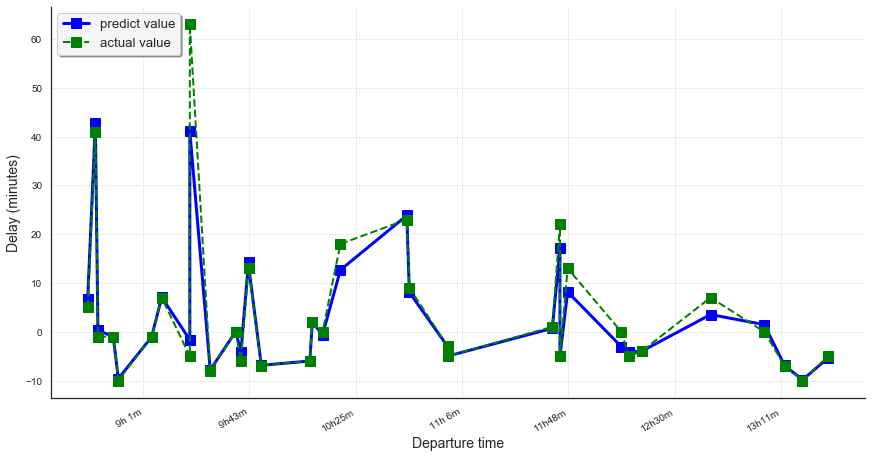

In [31]:
fig1 = Figure_style(13, 8, 1, 1) ; fig1.pos_update(0, 0)
fig1.cust_plot(sample_x,sample_y_pred, color='b',linewidth = 3,marker = ('b','s', 10), label='predict value')
fig1.cust_plot(sample_x,sample_y_test,color='g',linestyle='--', linewidth = 2, marker = ('g','s', 10), label='actual value')
fig1.style(); fig1.draw_legend('upper left')
fig1.set_ylabel('Delay (minutes)') ; fig1.set_xlabel('Departure time')
#____________________________________
# convert and set the x ticks labels
fct_convert = lambda x: (int(x/3600) , int(divmod(x,3600)[1]/60))
fig1.axs[fig1.ix, fig1.iy].set_xticklabels(['{:2.0f}h{:2.0f}m'.format(*fct_convert(x))
                                            for x in fig1.axs[fig1.ix, fig1.iy].get_xticks()]);

In [46]:
X_test

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [47]:
Y_pred

array([ -0.07333333,  -6.06      ,  -5.52      ,  -1.78      ,
        -5.12      ,  -5.00666667,  -3.1       ,  -5.26666667,
        -8.20666667,  -4.        ,  33.82      ,  -3.14666667,
        -2.15333333,  -8.02      ,  -6.1       , -10.08      ])